# Feature Importance

In [4]:
import uuid
import shap
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance

In [5]:
# generate data
def generate_data(n):
    """
    This function will generate n rows of sample data.
    
    params:
        n (Int) : The number of rows you want to generate
        
    returns:
        A pandas dataframe with n rows.
    """
    data = {
        'uuid' : [str(uuid.uuid4()) for _ in range(n)],
        'feature1' : [random.random() for _ in range(n)],
        'feature2' : [random.random() for _ in range(n)],
        'feature3' : [random.random() for _ in range(n)],
        'feature4' : [random.random() for _ in range(n)],
        'feature5' : [random.random() for _ in range(n)],
        'target' : [sum([random.random(), random.random(), random.random()]) for _ in range(n)]
    }
    return pd.DataFrame(data)

sample_df = generate_data(1000)
sample_df.head()

,uuid,feature1,feature2,feature3,feature4,feature5,target
0,c9b87046-50e3-4667-8186-d1d5fd8995fc,0.801383,0.653445,0.393746,0.412653,0.774194,1.453728
1,3d5e7a20-7c10-4a79-8f21-363477c48353,0.893997,0.508250,0.606489,0.280750,0.192523,1.711817
2,d32b4b2c-3acc-45d1-9915-dd5045c8f65c,0.383263,0.336637,0.322469,0.588506,0.205390,1.590883
3,917db23a-c408-4516-8415-56afab1c4eb3,0.033023,0.322514,0.762547,0.654564,0.851935,1.775683
4,3cb597f9-a9e9-4118-9aa9-6c068c8837a8,0.870963,0.250659,0.465478,0.989090,0.631094,0.726581


In [6]:
# train model
ft_cols = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5']
X = sample_df[ft_cols].values
Y = sample_df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3
)

gbr = GradientBoostingRegressor().fit(X_train, y_train)
svm = SVR(kernel='linear').fit(X_train, y_train)  # the .coef_ parameter is only available when using a linear kernel

### Permutation Feature Importance

In [7]:
def permutation_feature_importance(mdl, X, y, ft_cols, viz = True):
    """
    This function will calculate the permutation importance associated
    with the features the model was trained on.
    
    params:
        mdl (Model) : The model you want to calculate permutation importance
        X (Array -> Array) : Training data
        y (Array) : Target data
        ft_cols (List) : The list of feature names the model was trained on
        viz (Boolean) : Will create visualizations if True, will not otherwise
        
    returns:
        This function will return a dictionary where the keys are the feature names
        and the values are the associated importance.
    """
    pi = permutation_importance(mdl, X, y)
    importance_dct = dict(zip(ft_cols, pi.importances_mean))
    
    if viz:
        plt.clf()
        plt.barh(list(importance_dct.keys()), list(importance_dct.values()))
        plt.xlabel("Permutation Importance")
        plt.title("Permutation Feature Importance")
        plt.show()
    return importance_dct

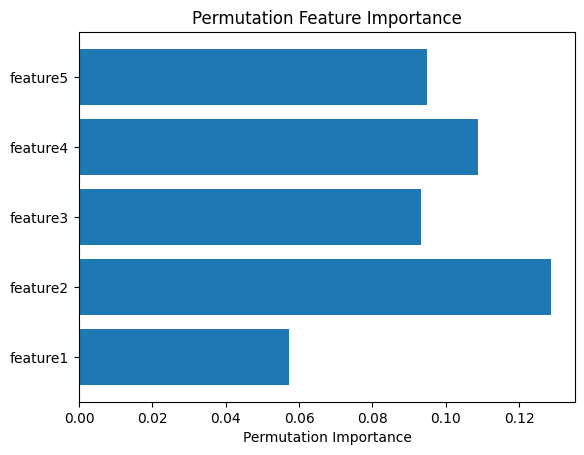

In [8]:
imp_dct = permutation_feature_importance(gbr, X, Y, ft_cols, viz = True)

### Coefficient Feature Importance

In [9]:
def coef_feature_importance(mdl, ft_cols, viz=True):
    """
    Given a linear model, this function will identify the importance 
    associated with feature based on their coefficient values.
    
    params:
        mdl (Model) : The model you want to identify coeficient importance on
        ft_cols (List) : The list of feature names 
        viz (Boolean) : True if you want to vizualize the results, False otherwise
        
    returns:
        This function will return a dictionary with keys as feature names and values
        being the coefficient associated to that feature.
    """
    # .coef_ returns a nested array
    imp = mdl.coef_[0]
    importance_dct = dict(zip(ft_cols, imp))
    
    if viz:
        plt.clf()
        plt.barh(list(importance_dct.keys()), list(importance_dct.values()))
        plt.xlabel("Coefficient Importance")
        plt.title("Coefficient Feature Importance")
        plt.show()
    
    return importance_dct

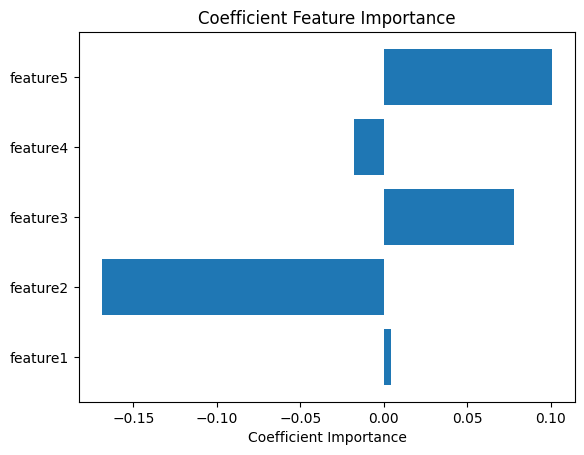

In [10]:
ci = coef_feature_importance(svm, ft_cols, True)

### Tree Feature Importance

In [11]:
def tree_feature_importance(mdl, ft_cols, viz=True):
    """
    This function will identify the feature importance associated with
    tree based models.
    
    params:
        mdl (Model) : The model you want to identify coeficient importance on
        ft_cols (List) : The list of feature names 
        viz (Boolean) : True if you want to vizualize the results, False otherwise
        
    returns:
        This function will return a dictionary with keys as feature names and values
        being the coefficient associated to that feature.
    """
    imp = mdl.feature_importances_
    importance_dct = dict(zip(ft_cols, imp))
    
    if viz:
        plt.clf()
        plt.barh(list(importance_dct.keys()), list(importance_dct.values()))
        plt.xlabel("Tree Based Importance")
        plt.title("Tree Based Feature Importance")
        plt.show()
    
    return importance_dct

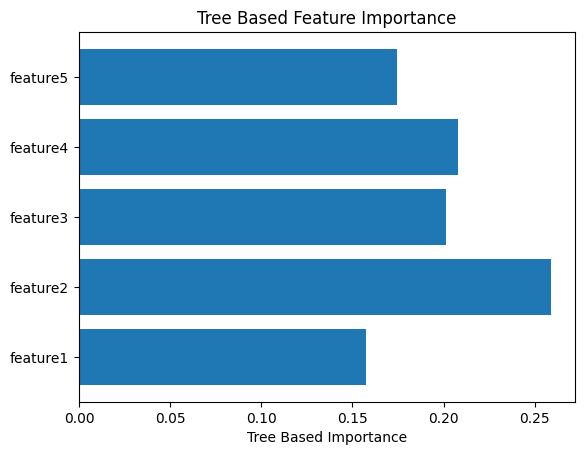

In [12]:
ti = tree_feature_importance(gbr, ft_cols, True)

### SHAP 

In [13]:
def shap_feature_importance(mdl, X, ft_cols, mdl_type):
    """
    This function will generate summary plots using the SHAP library.
    
    params:
        mdl (Model) : The model you want to calculate permutation importance
        X (Array -> Array) : Training data
        ft_cols (List) : The list of feature names the model was trained on
        mdl_type (String) : "linear" or "tree"
        
    returns:
        A series of visualizations associated with the feature importance of
        the model.
    """
    
    if mdl_type == "linear":
        explainer = shap.LinearExplainer(mdl, X)
    elif mdl_type == "tree":
        explainer = shap.TreeExplainer(mdl)
    else:
        raise("Passed in an incorrect model type")
    
    shap_values = explainer.shap_values(X)
    
    shap.summary_plot(
        shap_values, 
        features=X, 
        feature_names=ft_cols
    )
    
    shap.summary_plot(
        shap_values, 
        features=X,
        feature_names=ft_cols, 
        plot_type='bar'
    )
    
    i = 1
    shap.force_plot(
        explainer.expected_value, 
        shap_values[i], 
        features=X_train[i], 
        feature_names=ft_cols
    )

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


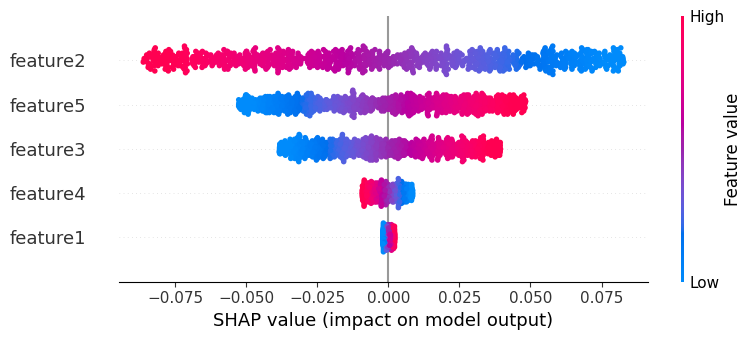

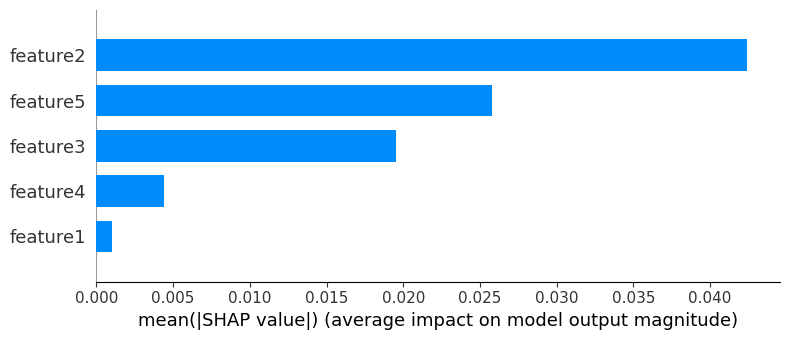

In [14]:
shap_feature_importance(svm, X, ft_cols, "linear")

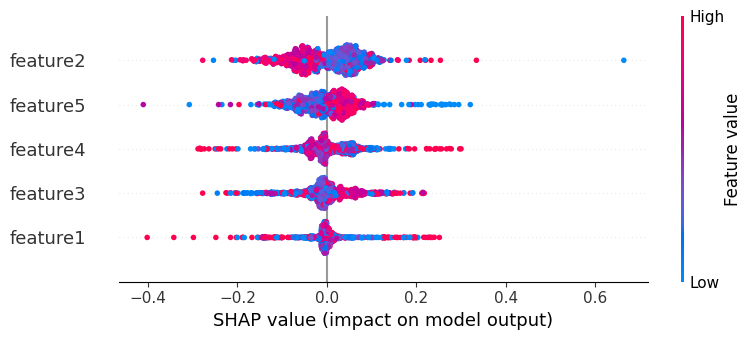

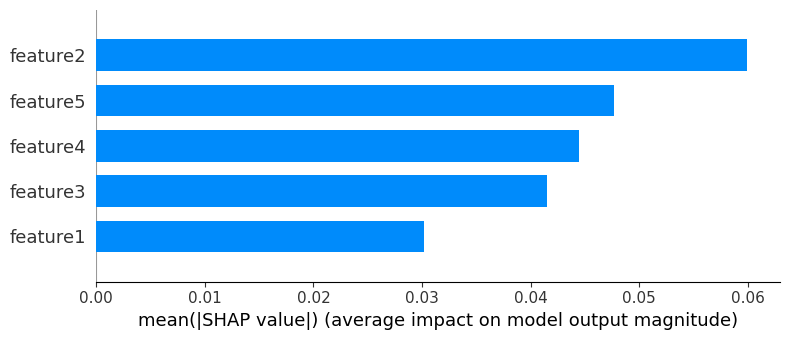

In [15]:
shap_feature_importance(gbr, X, ft_cols, "tree")